Mounted at /content/drive
Found 272 files.


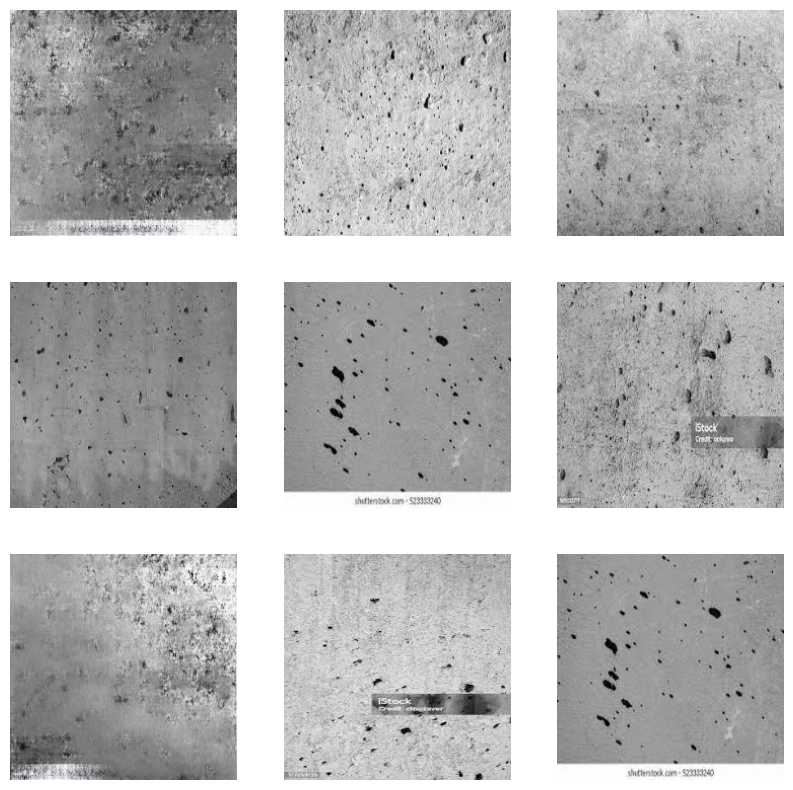

In [ ]:
# Step 1: Mount Google Drive and Load the Dataset

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your dataset
dataset_path = '/content/drive/My Drive/newdata'  # Update this path if needed

# Load images using TensorFlow's image_dataset_from_directory
batch_size = 32  # Adjust based on your system's memory
img_height = 224
img_width = 224

# Load the dataset
dataset = image_dataset_from_directory(
    dataset_path,
    label_mode=None,  # No labels, since this is unsupervised
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Normalize images to the range [-1, 1] (required for GANs)
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1  # Scale to [-1, 1]
    return image

dataset = dataset.map(normalize)

# Visualize a few images from the dataset
for images in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy() + 1) / 2)  # Rescale to [0, 1] for display
        plt.axis("off")
    plt.show()

In [ ]:
# Step 2: Define the DCGAN Generator and Discriminator

from tensorflow.keras import layers

# Define the Generator
def build_generator():
    model = tf.keras.Sequential()

    # Start with a dense layer
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))  # Input is random noise of size 100
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape into a 7x7 feature map
    model.add(layers.Reshape((7, 7, 256)))

    # Upsample to 14x14
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 28x28
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 56x56
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 112x112
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final layer to get 224x224 image
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Define the Discriminator
def build_discriminator():
    model = tf.keras.Sequential()

    # Input is a 224x224 image
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[224, 224, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample to 112x112
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample to 56x56
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample to 28x28
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and output a single value (real/fake)
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Create instances of the generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Print the summary of the models
print("Generator Summary:")
generator.summary()

print("\nDiscriminator Summary:")
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generator Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 56, 56, 32)          │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 112, 112, 16)        │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 112, 112, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 224, 224, 3)         │           1,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,394,736 (9.14 MB)

 Trainable params: 2,369,168 (9.04 MB)

 Non-trainable params: 25,568 (99.88 KB)


Discriminator Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 112, 112, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 56, 56, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 512)         │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         100,353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,406,913 (16.81 MB)

 Trainable params: 4,406,913 (16.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 3: Define the Loss Functions and Optimizers

# Import necessary libraries
from tensorflow.keras import losses, optimizers

# Define the loss function (Binary Cross-Entropy)
cross_entropy = losses.BinaryCrossentropy(from_logits=True)

# Discriminator Loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Real images should be classified as 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Fake images should be classified as 0
    total_loss = real_loss + fake_loss
    return total_loss

# Generator Loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # Generator wants fake images to be classified as 1

# Define optimizers for both networks
generator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Print the optimizers
print("Generator Optimizer:", generator_optimizer)
print("Discriminator Optimizer:", discriminator_optimizer)

Generator Optimizer: <keras.src.optimizers.adam.Adam object at 0x7f6da83ee250>
Discriminator Optimizer: <keras.src.optimizers.adam.Adam object at 0x7f6da8309610>


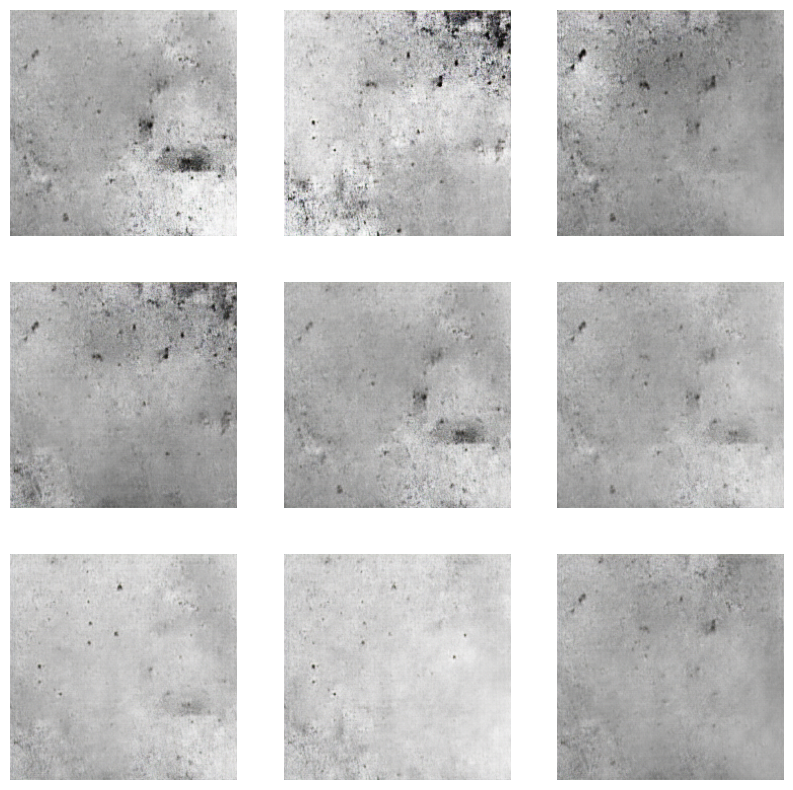

Checkpoint saved at epoch 2000
Epoch 2000/2000, Generator Loss: 7.752352714538574, Discriminator Loss: 0.032050881534814835, Time: 5.140360355377197
Final model saved to Google Drive.


In [ ]:
# Step 4: Training the GAN (Optimized Hyperparameters and Increased Epochs)

import os
import time
from IPython import display
import tensorflow as tf
import matplotlib.pyplot as plt

# Define training parameters
epochs = 2000  # Increased to 1000 epochs for better training
noise_dim = 100  # Size of the noise vector for the generator
num_examples_to_generate = 9  # Number of images to generate for visualization
seed = tf.random.normal([num_examples_to_generate, noise_dim])  # Fixed seed for consistent visualization
batch_size = 32  # Batch size (can be adjusted based on your dataset size)

# Create a checkpoint directory to save models
checkpoint_dir = '/content/drive/My Drive/gan_checkpoints22'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Create a directory to save generated images
generated_images_dir = '/content/drive/My Drive/generated_images22'
if not os.path.exists(generated_images_dir):
    os.makedirs(generated_images_dir)

# Define a checkpoint to save the generator and discriminator
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

# Function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)  # Generate images
    predictions = (predictions + 1) / 2.0  # Rescale to [0, 1] for display

    # Plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i + 1)
        plt.imshow(predictions[i], cmap='gray')  # Use 'gray' colormap for grayscale images
        plt.axis('off')
    plt.savefig(f'{generated_images_dir}/epoch_{epoch:04d}.png')  # Save the figure
    plt.show()

# Training loop
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])  # Generate random noise

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)  # Generate fake images

        real_output = discriminator(images, training=True)  # Discriminator on real images
        fake_output = discriminator(generated_images, training=True)  # Discriminator on fake images

        gen_loss = generator_loss(fake_output)  # Calculate generator loss
        disc_loss = discriminator_loss(real_output, fake_output)  # Calculate discriminator loss

    # Compute gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Main training function
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        # Train for one epoch
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        # Generate and save images every 10 epochs
        if (epoch + 1) % 50 == 0:
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 50 epochs
        if (epoch + 1) % 100 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"Checkpoint saved at epoch {epoch + 1}")

        # Print losses and time taken
        print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}, Time: {time.time() - start}')

# Start training
train(dataset, epochs)

# Save the final model
checkpoint.save(file_prefix=checkpoint_prefix)
print("Final model saved to Google Drive.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generator restored from checkpoint: /content/drive/My Drive/gan_checkpoints/ckpt-10


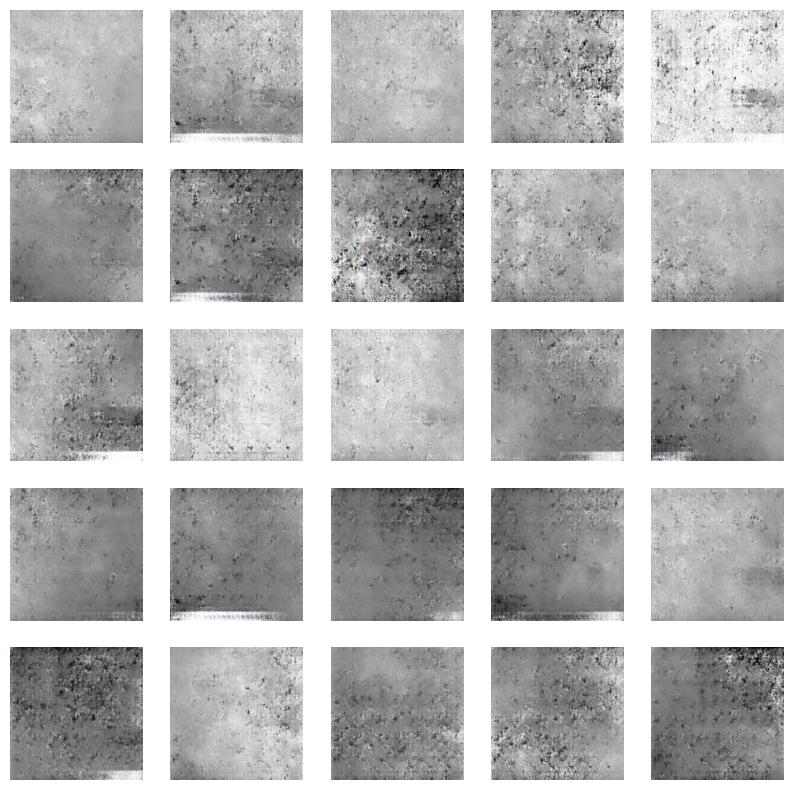

In [ ]:
# Step 5: Reload the Model and Generate Images

# Add these imports at the beginning
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the generator architecture (same as during training)
def build_generator():
    model = tf.keras.Sequential()

    # Start with a dense layer
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))  # Input is random noise of size 100
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape into a 7x7 feature map
    model.add(layers.Reshape((7, 7, 256)))

    # Upsample to 14x14
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 28x28
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 56x56
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 112x112
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final layer to get 224x224 image
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Create an instance of the generator
generator = build_generator()

# Load the trained generator from the latest checkpoint
checkpoint_dir = '/content/drive/My Drive/gan_checkpoints'
checkpoint = tf.train.Checkpoint(generator=generator)
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print("Generator restored from checkpoint:", latest_checkpoint)
else:
    raise FileNotFoundError("No checkpoint found in the specified directory.")


noise_dim = 100  # Define noise dimension (must match the input size of the generator)


# Generate new images
num_images_to_generate = 25  # Number of images to generate
noise = tf.random.normal([num_images_to_generate, noise_dim])  # Generate random noise
generated_images = generator(noise, training=False)

# Rescale images from [-1, 1] to [0, 1] for display
generated_images = (generated_images + 1) / 2.0

# Display the generated images
plt.figure(figsize=(10, 10))
for i in range(generated_images.shape[0]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(generated_images[i].numpy().squeeze(), cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

# Define the generator architecture (same as during training)
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# Create an instance of the generator
generator = build_generator()

# Load the trained generator from the latest checkpoint
checkpoint_dir = '/content/drive/My Drive/gan_checkpoints'
checkpoint = tf.train.Checkpoint(generator=generator)
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print("Generator restored from checkpoint:", latest_checkpoint)
else:
    raise FileNotFoundError("No checkpoint found in the specified directory.")

# Define noise dimension and number of images to generate
noise_dim = 100
num_images_to_generate = 1000

# Create a directory to save generated images
save_dir = '/content/drive/My Drive/generated_images'
os.makedirs(save_dir, exist_ok=True)

# Generate images and save them
for i in range(num_images_to_generate):
    noise = tf.random.normal([1, noise_dim])
    generated_image = generator(noise, training=False)
    generated_image = (generated_image + 1) / 2.0  # Rescale from [-1, 1] to [0, 1]

    # Convert to uint8 format
    img_array = (generated_image.numpy().squeeze() * 255).astype(np.uint8)
    img = Image.fromarray(img_array)

    # Save image
    img_path = os.path.join(save_dir, f'image_{i+1}.png')
    img.save(img_path)

    if (i + 1) % 100 == 0:
        print(f"Saved {i + 1} images...")

print("Image generation complete. Images saved in:", save_dir)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generator restored from checkpoint: /content/drive/My Drive/gan_checkpoints/ckpt-10


Saved 100 images...
Saved 200 images...
Saved 300 images...
Saved 400 images...
Saved 500 images...
Saved 600 images...
Saved 700 images...
Saved 800 images...
Saved 900 images...
Saved 1000 images...
Image generation complete. Images saved in: /content/drive/My Drive/generated_images
